In [1]:
#for retreiving the correct data file
import glob

# for data structures and tools
import numpy as np
import pandas as pd

#for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#for some analyses
from scipy import stats
from scipy.signal import butter, filtfilt, freqz

# for interactive plots
import plotly.tools as pt
pt.set_credentials_file(username='sleepandcognitionlab', api_key='l9O6wZNzv8FJFydIwjRt')
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go

In [572]:
participant_num = 15

In [573]:
#Stimulus events
onset_val = 40
offset_val = 50

stim_indices = []

word_list = ['twin', 
             'spring', 
             'cloak', 
             'marsh',
             'loaf',
             'belt',
             'dress',
             'color',
             'record',
             'pump',
             'flour',
             'surf',
             'chest',
             'swing',
             'actress',
             'wing',
             'grin',
             'shave',
             'crash',
             'cook']

base_path = '../../Data/'

# This is the path of the file to be analyzed
tsv_path = base_path + '%02d/%02dTraining.tsv' % (participant_num, participant_num)
print('ANALYZING FILE: ' + tsv_path)

ANALYZING FILE: ../../Data/15/15Training.tsv


In [574]:
# Change_threshold determines how much psize should 
CHANGE_THRESHOLD = 1
# QTHRESHOLD determines what percentage of the surrounding samples must be below the change threshold
QTHRESHOLD = 0.8
# WINDOW determines how many surrounding samples (including itself) are used to calculate a points average
WINDOW = 9
# TRIALS_COUNT is the number of stimulus trials in the entire experiment
TRIALS_COUNT = len(word_list)

def checkEvents(series, seq):
    # This function checks if the events in the participant file are all present and in the correct order.
    # If there its correct, it will print out a confirmation, otherwise it will raise an error
    # 
    # Arguments
    # series: should be a series of events (stimulus, block, start, and stop) - not the probe values!
    # seq: which SART sequence it is, either 'A' or 'B'
    
    if seq not in ['A', 'B']:
        raise Exception("Incorrect seq argument, must be 'A' or 'B'")
    
    if seq == 'A':
        correctColumn = 'seqA'
    else:
        correctColumn = 'seqB'
    
    # Check for missing events by comparing each row of the event_df to the correct_seq
    block_location = 0
    for i in range(len(correct_seq)):
        try: event_df_cell = int(series.iloc[i,])
        except KeyError:
            raise Exception("File is missing events starting at index %d" %i)
        if event_df_cell == correct_seq.get_value(i, correctColumn):
            if correct_seq.get_value(i, correctColumn) == block_val:
                block_location += 1
            continue
        else:
            print("Missing event at index %d, in block %d" %(i, block_location))
            print("Current file shows %s when it should be %s." %(series.iloc[i,], correct_seq.get_value(i, correctColumn)))
            print(series.iloc[i-3:i+3])
            print(correct_seq.loc[i-3:i+3])
            raise Exception('See above...')

    print(bordered('The file has the correct sequence of events!'))

def qualityChecker(series):
    # This function takes a series of raw pupil data and returns the quality score for each sample.
    # To calculate the quality score, the series is filtered, then the discrete difference is calculated. Each sample is
    # marked  good (1) if the diff is < the CHANGE_THRESHOLD, and bad (0) if its >= it or if the original sample was a 0.
    # Lastly, a moving average is calculated and np.nan's are appended to make it the same length as the original data
    #
    # Arguments
    # series: a series of raw pupil data (left or right)
    
    original_len = len(series)
    
    processed = myFilter(series)
    processed = np.absolute(np.diff(processed))
    
    #add a NaN to the end of "processed" to make it the same length as the original series (it is shortened when doing np.diff)
    processed = np.append(processed, np.nan)
    
    processed = [0 if diff >= CHANGE_THRESHOLD or original_val == 0 else 1 for diff, original_val in zip(processed, series)]
    
    #Calculate the moving average so that quality of a sample is also defined by its surrounding points.
    if WINDOW%2 == 0:
        raise "ERROR: Window must be odd"
    pendNumber = int((WINDOW-1)/2)
    processed = np.convolve(processed, np.ones((WINDOW,))/WINDOW, mode='valid')
    processed = np.append([np.nan]*pendNumber, np.append(processed, [np.nan]*pendNumber))
    
    return processed
    
    
def myFilter(series):
    # Function applies a linear filter fowards and backwards. np.nan's will be replaced with median values so it can
    # work properly.
    #
    # Arguments
    # series: a series which you want to filter.
    
    #
    series = [series.median() if np.isnan(val) else val for val in series]
    
    # Determine the cutoff frequency between 0 and 1,
    # where 1 corresponds to the Nyquist rate...
    Wn = 0.66
    b, a = butter(10, Wn, analog=False)
    series = filtfilt(b, a, series)
    
    return series

def psizeMerger(row):
    
    #if both signals good-> average
    #if only one good-> use that one's value
    #if neither good-> nan (to be interpolated)
    if row['lquality'] >= QTHRESHOLD and row['rquality'] >= QTHRESHOLD:
        return (row['lpsize'] + row['rpsize'])/2
    elif row['lquality'] >= QTHRESHOLD:
        return row['lpsize']
    elif row['rquality'] >= QTHRESHOLD:
        return row['rpsize']
    else:
        return np.nan

def trialCalc(eyeData, stimIndices, trialFun, trialDuration=30, trialBuffer=6, beforeStim=True):
    #eyeData: a series of eye data...
    #stimIndices: a list of the indices where stimulus events occur
    #trialFun: a function to be applied to the trial
    #trialDuration: number of samples a trial should last
    #trialBuffer: number of samples spaced between the stimulus and the analysed window
    #beforeStim: whether you want to analyze the time before or after the stimulus (True: before stimulus, False: after stimulus)
    
    #check that there are the correct number of stimuli
    if len(stimIndices) != TRIALS_COUNT:
        raise Exception("Incorrect number of stimuli!")
    
    if trialDuration <= 0:
        raise Exception("trialDuration must a be positive integer!")
    
    #Apply the function to every trial window before or after stim
    if beforeStim:
        return [trialFun(eyeData.loc[idx-(trialDuration+trialBuffer):idx-trialBuffer,]) for idx in stimIndices]
    else:
        return [trialFun(eyeData.loc[idx+trialBuffer:idx+(trialDuration+trialBuffer),]) for idx in stimIndices]


def linRegSlope(series):
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(series)), series)
    
    return slope

def percentGoodSamples(series):
    # Returns the percent of samples greater than or equal to the quality threshold
    #
    # Arguments
    # series: a series of quality values calculated by the qualityChecker function
    numGood = sum(i >= QTHRESHOLD for i in series)
    return numGood/len(series)

def bordered(text):
    # Just makes text look pretty by placing it in a box...
    
    lines = text.splitlines()
    width = max(len(s) for s in lines)
    res = ['┌' + '─' * width + '┐']
    for s in lines:
        res.append('│' + (s + ' ' * width)[:width] + '│')
    res.append('└' + '─' * width + '┘')
    return '\n'.join(res)

In [575]:
# Open the eyetracking tsv file
# Ignore the warning that the program gives
raw_df = pd.DataFrame.from_csv(tsv_path, index_col=None, sep="\t")

In [576]:
# Create dataframe which contains logged messages
trial_df = raw_df.loc[raw_df['timestamp'] == 'MSG'].copy()
trial_df['state'] = trial_df['state'].apply(str)
trial_df.drop(['timestamp',
               'fix',
               'psize',
               'rawy',
               'avgx',
               'avgy',
               'Lrawx',
               'Lrawy',
               'Lavgx',
               'Lavgy',
               'Lpsize',
               'Lpupilx',
               'Lpupily',
               'Rrawx',
               'Rrawy',
               'Ravgx',
               'Ravgy',
               'Rpsize',
               'Rpupilx',
               'Rpupily'], axis=1, inplace=True)


# Rename columns
trial_df = trial_df.rename(columns = {'index': 'stimulusIdx', 
                                      'state': 'event', 
                                      'rawx': 'english'})


# Get rid of everything that is not a wordpair trial
trial_df = trial_df.loc[trial_df['english'].isin(word_list)]

# fix data types of the columns
trial_df['time'] = pd.datetools.to_datetime(trial_df['time'])
trial_df['event'] = trial_df['event'].astype(int)
trial_df['english'] = trial_df['english'].astype(str)

if trial_df.shape[0] != len(word_list):
    raise Exception("Incorrect number of words...")
else:
    stim_indices = trial_df.index.tolist()
    print(bordered("All Good"))
    print(bordered("Below is the trial df"))
trial_df

┌────────┐
│All Good│
└────────┘
┌─────────────────────┐
│Below is the trial df│
└─────────────────────┘


,time,event,english
317,2017-07-12 16:52:13.563,40,wing
563,2017-07-12 16:52:21.694,40,twin
809,2017-07-12 16:52:29.817,40,marsh
1054,2017-07-12 16:52:37.946,40,pump
1301,2017-07-12 16:52:46.720,40,crash
1546,2017-07-12 16:52:54.201,40,color
1792,2017-07-12 16:53:02.326,40,belt
2038,2017-07-12 16:53:10.452,40,grin
2284,2017-07-12 16:53:18.580,40,cloak
2530,2017-07-12 16:53:26.708,40,shave


In [577]:
# create dataframe for psize values and calculate the quality of each raw recording
rpsize = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'Rpsize']
lpsize = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'Lpsize']
rawx = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'rawx'].apply(pd.to_numeric)
rawy = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'rawy'].apply(pd.to_numeric)

psize_df = pd.DataFrame({'rpsize': rpsize, 'lpsize': lpsize, 'rawx': rawx, 'rawy': rawy})

psize_df['lquality'] = qualityChecker(lpsize)
psize_df['rquality'] = qualityChecker(rpsize)

# Next we will determine whether to use the left or right eye data for the analyses. We will choose the data that has the
# most 'good' samples
left_good_count = psize_df.loc[psize_df['lquality'] >= .8].size
right_good_count = psize_df.loc[psize_df['rquality'] >= .8].size

if left_good_count >= right_good_count:
    quality_col = 'lquality'
    psize_df['onePsize'] = psize_df['lpsize'].copy()
else:
    quality_col = 'rquality'
    psize_df['onePsize'] = psize_df['rpsize'].copy()

print(bordered('All Good!'))

┌─────────┐
│All Good!│
└─────────┘


In [578]:
# Replace all low quality samples with np.nans. This is done so we can interpolate (replace) them
psize_df.loc[psize_df[quality_col] < .8, 'onePsize'] = np.nan

# Interpolate all of the bad samples
psize_df['interpOne'] = psize_df['onePsize'].interpolate(method='linear')

# Filter the interpolated data 
psize_df['filtPsize'] = myFilter(psize_df['interpOne'])

print(bordered('All Good!'))

┌─────────┐
│All Good!│
└─────────┘


In [579]:
# Now that we have the interpolated, and filtered pupil size, we want to zscore it
psize_df['zPsize'] = stats.zscore(psize_df['filtPsize'])

print(bordered('All Good!'))

┌─────────┐
│All Good!│
└─────────┘


In [580]:
# Calculate the mean zscored pupil size
#(eyeData, stimIndices, trialFun, trialDuration=30, trialBuffer=6, beforeStim=True)
trial_df['baselineZMean'] = trialCalc(psize_df['zPsize'], stim_indices, np.mean)

trial_df['postStimZMean'] = trialCalc(eyeData=psize_df['zPsize'], stimIndices=stim_indices, 
                                      trialFun=np.mean, trialDuration=15, trialBuffer=0, beforeStim=False)

# Calculate the mean X and Y gaze position
trial_df['baselineXMean'] = trialCalc(psize_df['rawx'], stim_indices, np.mean)
trial_df['baselineYMean'] = trialCalc(psize_df['rawy'], stim_indices, np.mean)

trial_df['postStimXMean'] = trialCalc(eyeData=psize_df['rawx'], stimIndices=stim_indices, 
                                      trialFun=np.mean, trialDuration=15, trialBuffer=0, beforeStim=False)
trial_df['postStimYMean'] = trialCalc(eyeData=psize_df['rawy'], stimIndices=stim_indices, 
                                      trialFun=np.mean, trialDuration=15, trialBuffer=0, beforeStim=False)

# Calculate the percent of samples above the quality threshold for each trial
trial_df['baselineQuality'] = trialCalc(psize_df[quality_col], stim_indices, percentGoodSamples)

trial_df['postStimQuality'] = trialCalc(eyeData=psize_df['zPsize'], stimIndices=stim_indices, 
                                      trialFun=percentGoodSamples, trialDuration=15, trialBuffer=0, beforeStim=False)

# Calculate peak response and slope of response
trial_df['peakResp'] = trialCalc(eyeData=psize_df['zPsize'], stimIndices=stim_indices, 
                                      trialFun=max, trialDuration=15, trialBuffer=0, beforeStim=False)
trial_df['slopeResp'] = trialCalc(eyeData=psize_df['zPsize'], stimIndices=stim_indices, 
                                      trialFun=linRegSlope, trialDuration=15, trialBuffer=0, beforeStim=False)

print(bordered('All Good!'))
print(bordered('Below is the current trial dataframe:'))
trial_df

┌─────────┐
│All Good!│
└─────────┘
┌─────────────────────────────────────┐
│Below is the current trial dataframe:│
└─────────────────────────────────────┘


,time,event,english,baselineZMean,postStimZMean,baselineXMean,baselineYMean,postStimXMean,postStimYMean,baselineQuality,postStimQuality,peakResp,slopeResp
317,2017-07-12 16:52:13.563,40,wing,-0.629658,-0.706489,394.606394,247.868319,198.146433,153.400113,0.000000,0.000000,-0.687286,-0.002744
563,2017-07-12 16:52:21.694,40,twin,0.896836,0.915023,442.652777,289.206687,522.867360,393.169393,0.096774,0.800000,1.178385,-0.000621
809,2017-07-12 16:52:29.817,40,marsh,0.622281,0.768474,552.416558,341.450400,569.421987,378.734360,1.000000,0.000000,0.777765,0.000450
1054,2017-07-12 16:52:37.946,40,pump,0.787577,0.645099,492.719555,364.949458,527.512487,401.565933,0.000000,0.266667,1.012074,-0.021519
1301,2017-07-12 16:52:46.720,40,crash,-0.661870,-1.079277,469.550919,356.505690,392.887007,347.930360,0.354839,0.000000,-0.003973,0.183022
1546,2017-07-12 16:52:54.201,40,color,0.381070,0.656498,503.722097,340.294190,430.843427,375.957913,0.935484,0.000000,0.765014,0.011127
1792,2017-07-12 16:53:02.326,40,belt,0.326147,1.115859,458.035842,348.630374,491.438253,314.318500,0.806452,1.000000,1.243465,-0.004507
2038,2017-07-12 16:53:10.452,40,grin,0.414505,0.918382,477.585877,371.340065,457.691907,289.673413,0.903226,1.000000,0.974135,0.007893
2284,2017-07-12 16:53:18.580,40,cloak,0.238375,0.529459,465.115877,320.476558,462.793280,334.455993,0.129032,0.333333,1.164456,0.081762
2530,2017-07-12 16:53:26.708,40,shave,0.687659,0.886319,497.278281,372.199606,486.983300,355.397467,0.032258,0.733333,1.116622,-0.023115


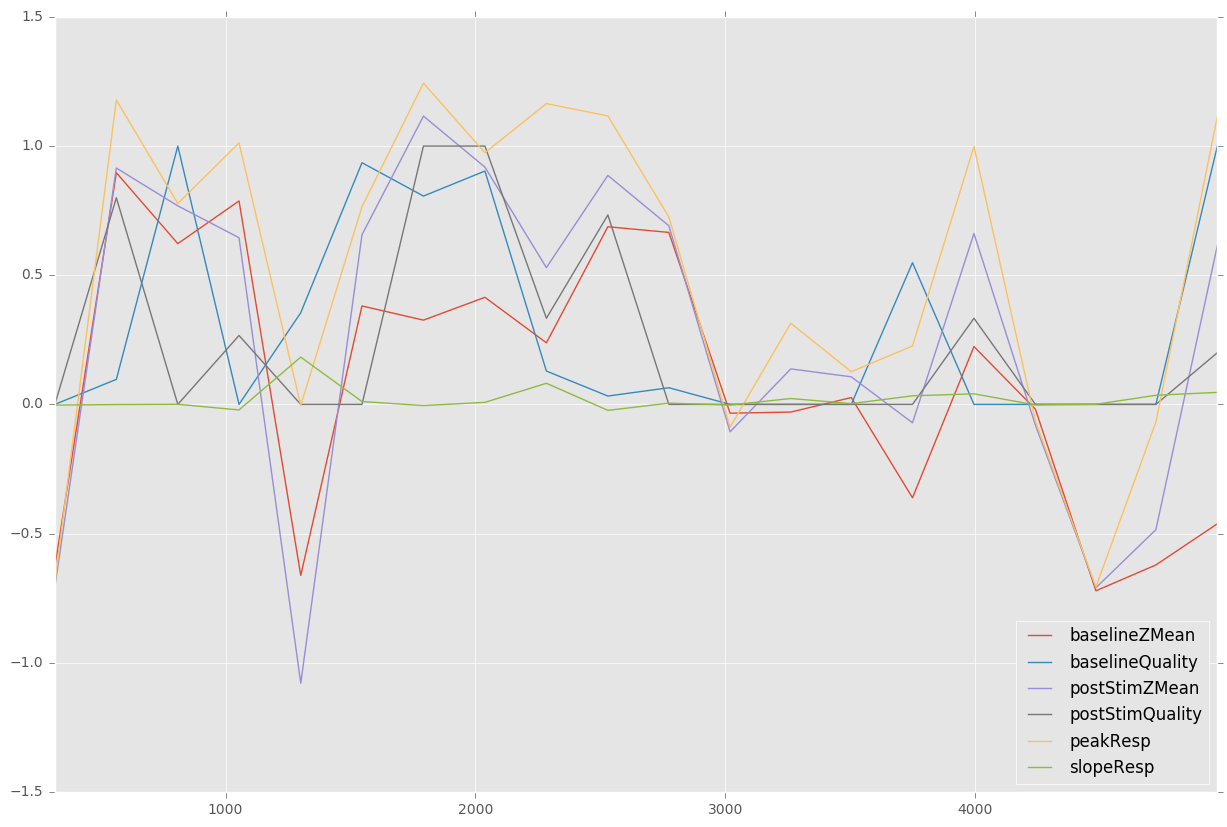

In [581]:
plt.figure(figsize=(15,10))
trial_df['baselineZMean'].plot()
trial_df['baselineQuality'].plot()
trial_df['postStimZMean'].plot()
trial_df['postStimQuality'].plot()
trial_df['peakResp'].plot()
trial_df['slopeResp'].plot()
plt.legend(loc='lower right')

In [582]:
# Get the training and testing response data
train_path = base_path + '%02d/%02dTraining.csv' % (participant_num, participant_num)
test_path = base_path + '%02d/%02dTest.csv' % (participant_num, participant_num)

# Open the eyetracking csv's 
train_df = pd.DataFrame.from_csv(train_path, index_col=None)
test_df = pd.DataFrame.from_csv(test_path, index_col=None)

train_df

,icelandic,english,englishResponse,correct,totalTime
0,dæla,pump,pump,1,207.149
1,gormur,spring,spring,1,207.149
2,skikkja,cloak,cloak,1,207.149
3,sveifla,swing,swing,1,207.149
4,kjóll,dress,dress,1,207.149
5,reim,belt,belt,1,207.149
6,litur,color,color,1,207.149
7,leikkona,actress,actress,1,207.149
8,glott,grin,grin,1,207.149
9,votlendi,marsh,marsh,1,207.149


In [583]:
if 'icelandic' not in trial_df.columns.tolist():
    trial_df = trial_df.join(train_df.set_index('english'), on='english')
    trial_df = trial_df.join(test_df.set_index('english'), on='english', lsuffix='_train', rsuffix='_test')
try: trial_df.drop('icelandic_test', axis=1, inplace=True)
except:
    pass
trial_df['participant'] = participant_num
trial_df['learnPosition'] = range(1, len(word_list)+1)
trial_df

,time,event,english,baselineZMean,postStimZMean,baselineXMean,baselineYMean,postStimXMean,postStimYMean,baselineQuality,...,slopeResp,icelandic_train,englishResponse_train,correct_train,totalTime_train,englishResponse_test,correct_test,totalTime_test,participant,learnPosition
317,2017-07-12 16:52:13.563,40,wing,-0.629658,-0.706489,394.606394,247.868319,198.146433,153.400113,0.000000,...,-0.002744,vængur,wing,1,207.149,NaN,0,53.874,15,1
563,2017-07-12 16:52:21.694,40,twin,0.896836,0.915023,442.652777,289.206687,522.867360,393.169393,0.096774,...,-0.000621,tvíburi,twins,0,207.149,NaN,0,53.874,15,2
809,2017-07-12 16:52:29.817,40,marsh,0.622281,0.768474,552.416558,341.450400,569.421987,378.734360,1.000000,...,0.000450,votlendi,marsh,1,207.149,NaN,0,53.874,15,3
1054,2017-07-12 16:52:37.946,40,pump,0.787577,0.645099,492.719555,364.949458,527.512487,401.565933,0.000000,...,-0.021519,dæla,pump,1,207.149,NaN,0,53.874,15,4
1301,2017-07-12 16:52:46.720,40,crash,-0.661870,-1.079277,469.550919,356.505690,392.887007,347.930360,0.354839,...,0.183022,árekstur,crash,1,207.149,NaN,0,53.874,15,5
1546,2017-07-12 16:52:54.201,40,color,0.381070,0.656498,503.722097,340.294190,430.843427,375.957913,0.935484,...,0.011127,litur,color,1,207.149,NaN,0,53.874,15,6
1792,2017-07-12 16:53:02.326,40,belt,0.326147,1.115859,458.035842,348.630374,491.438253,314.318500,0.806452,...,-0.004507,reim,belt,1,207.149,surf,0,53.874,15,7
2038,2017-07-12 16:53:10.452,40,grin,0.414505,0.918382,477.585877,371.340065,457.691907,289.673413,0.903226,...,0.007893,glott,grin,1,207.149,NaN,0,53.874,15,8
2284,2017-07-12 16:53:18.580,40,cloak,0.238375,0.529459,465.115877,320.476558,462.793280,334.455993,0.129032,...,0.081762,skikkja,cloak,1,207.149,NaN,0,53.874,15,9
2530,2017-07-12 16:53:26.708,40,shave,0.687659,0.886319,497.278281,372.199606,486.983300,355.397467,0.032258,...,-0.023115,raka,shave,1,207.149,NaN,0,53.874,15,10


In [584]:
trial_df = trial_df.sort_values(by='english')
try: trial_df.drop(['time', 'event'], axis=1, inplace=True)
except:
    pass
trial_df

,english,baselineZMean,postStimZMean,baselineXMean,baselineYMean,postStimXMean,postStimYMean,baselineQuality,postStimQuality,peakResp,slopeResp,icelandic_train,englishResponse_train,correct_train,totalTime_train,englishResponse_test,correct_test,totalTime_test,participant,learnPosition
3504,actress,0.026461,0.106715,275.497190,334.884516,111.430140,101.830353,0.000000,0.000000,0.126583,0.002862,leikkona,actress,1,207.149,NaN,0,53.874,15,14
1792,belt,0.326147,1.115859,458.035842,348.630374,491.438253,314.318500,0.806452,1.000000,1.243465,-0.004507,reim,belt,1,207.149,surf,0,53.874,15,7
3262,chest,-0.029741,0.137410,457.644261,318.780194,448.526587,357.373360,0.000000,0.000000,0.314188,0.022759,bringa,chest,1,207.149,friend,0,53.874,15,13
2284,cloak,0.238375,0.529459,465.115877,320.476558,462.793280,334.455993,0.129032,0.333333,1.164456,0.081762,skikkja,cloak,1,207.149,NaN,0,53.874,15,9
1546,color,0.381070,0.656498,503.722097,340.294190,430.843427,375.957913,0.935484,0.000000,0.765014,0.011127,litur,color,1,207.149,NaN,0,53.874,15,6
4241,cook,-0.018981,-0.080492,495.137452,327.049797,524.883453,325.937380,0.000000,0.000000,-0.065114,-0.002197,elda,cook,1,207.149,cook,1,53.874,15,17
1301,crash,-0.661870,-1.079277,469.550919,356.505690,392.887007,347.930360,0.354839,0.000000,-0.003973,0.183022,árekstur,crash,1,207.149,NaN,0,53.874,15,5
4483,dress,-0.721545,-0.709766,392.113842,447.942519,396.271033,331.091820,0.000000,0.000000,-0.706821,0.000421,kjóll,dress,1,207.149,NaN,0,53.874,15,18
3749,flour,-0.361462,-0.071258,403.384994,364.609703,458.951607,381.403833,0.548387,0.000000,0.225995,0.033178,mjöl,flour,1,207.149,NaN,0,53.874,15,15
2038,grin,0.414505,0.918382,477.585877,371.340065,457.691907,289.673413,0.903226,1.000000,0.974135,0.007893,glott,grin,1,207.149,NaN,0,53.874,15,8


In [585]:
trial_df.to_csv(path_or_buf=base_path + 'Word Pair Analysis Output/%02dIceProcessed.csv' % participant_num, index=False)